In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten

In [3]:
df = pd.read_csv("/content/ETH-USD.csv")

In [4]:
# Kiểm tra dữ liệu
print(df.head())
print(df.info())

         Date        Open        High         Low       Close   Adj Close  \
0  2019-03-01  136.836243  138.995270  136.434784  136.443619  136.443619   
1  2019-03-02  136.350082  137.184799  132.436386  134.206955  134.206955   
2  2019-03-03  134.786118  135.849289  131.328857  132.249420  132.249420   
3  2019-03-04  132.157883  132.729141  125.402702  127.774124  127.774124   
4  2019-03-05  127.792953  138.229980  126.735298  137.822388  137.822388   

       Volume  
0  3756124824  
1  3747176425  
2  3454374053  
3  4008171341  
4  4764849990  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1920 non-null   object 
 1   Open       1920 non-null   float64
 2   High       1920 non-null   float64
 3   Low        1920 non-null   float64
 4   Close      1920 non-null   float64
 5   Adj Close  1920 non-null   float64
 6   Volume    

In [5]:
# Sử dụng cột 'Close' làm dữ liệu để dự đoán
df1 = df['Close'].values.reshape(-1, 1)

In [6]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(df1)

In [7]:
# Chia dữ liệu thành tập train và test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [8]:
# Kiểm tra kích thước của tập train và test
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1344
Test data size: 576


In [9]:
# Hàm tạo dataset từ chuỗi dữ liệu
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
# Tạo các tập X và Y từ dữ liệu train và test
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [12]:
# Định hình lại dữ liệu để phù hợp với đầu vào của TimesNet
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
# Xây dựng mô hình TimesNet
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
20/20 [==============================] - 1s 12ms/step - loss: 0.0281
Epoch 2/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0044
Epoch 3/100
20/20 [==============================] - 0s 16ms/step - loss: 0.0031
Epoch 4/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0027
Epoch 5/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0022
Epoch 6/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0021
Epoch 7/100
20/20 [==============================] - 0s 16ms/step - loss: 0.0017
Epoch 8/100
20/20 [==============================] - 0s 16ms/step - loss: 0.0016
Epoch 9/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0016
Epoch 10/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0014
Epoch 11/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0012
Epoch 12/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0011
Epoch 13/100
20/20 [=====

In [15]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

15/15 [==============================] - 0s 3ms/step


In [16]:
# Chuyển đổi giá trị về phạm vi gốc
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [17]:
# Đánh giá mô hình
train_rmse = np.sqrt(np.mean((train_predict - y_train)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test)**2))
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
test_mse = np.mean((y_test - test_predict)**2)

print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Test MAPE:', test_mape)
print('Test MSE:', test_mse)

Train RMSE: 125.72098107704919
Test RMSE: 139.9444268559776
Test MAPE: 5.100733339448313
Test MSE: 19584.44260804807


In [18]:
# Dự đoán 30 ngày tiếp theo và in ra màn hình
x_input = test_data[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.59790777 0.61295149 0.63854157 0.65264274 0.66657997 0.69660977
 0.68729693 0.70710649 0.70434052 0.7190048  0.74866357 0.73261135
 0.78881953 0.80054378 0.80431139 0.8092796  0.8019998  0.84140269
 0.82307402 0.8286433  0.80241398 0.77095152 0.72578276 0.75121155
 0.72474585 0.6480962  0.72376913 0.71942968 0.68554606 0.68616416
 0.71127167 0.74025132 0.73953263 0.72094495 0.73395759 0.72343159
 0.72261019 0.75236934 0.72199032 0.67353848 0.68081434 0.68477024
 0.68239753 0.6899055  0.7110288  0.76245899 0.72201867 0.73022326
 0.72203664 0.66626424 0.61561329 0.64795235 0.63618127 0.63263341
 0.61132255 0.62861498 0.62717947 0.64809812 0.6458991  0.65746217
 0.66134595 0.64430739 0.64786039 0.64225689 0.66820689 0.67046287
 0.66039249 0.61718439 0.60814422 0.61205443 0.63659425 0.63957936
 0.6437637  0.62791332 0.61596994 0.6089679  0.62223251 0.59538368
 0.59576884 0.59940596 0.60379983 0.58929341 0.62245289 0.60290043
 0.63458992 0.6407221  0.62985192 0.75577232 0.782

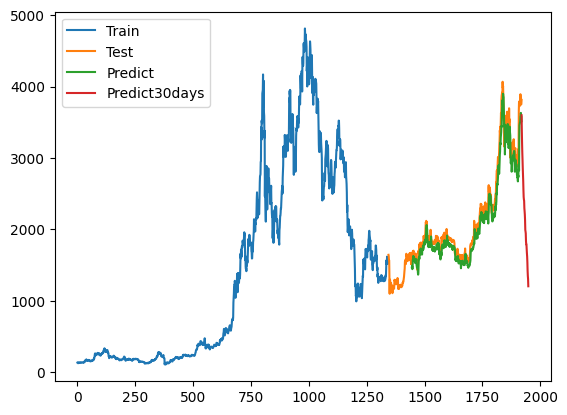

In [19]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(test_predict))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [20]:
x_input.shape

(1, 100, 1)

In [21]:
train_size_82 = int(0.8 * len(df1))
test_size_82 = len(df1) - train_size_82
train_data_82 = df1[:train_size_82]
test_data_82 = df1[train_size_82:train_size_82+test_size_82]

In [22]:
X_train_82, y_train_82 = create_dataset(train_data_82, time_step)
X_test_82, ytest_82 = create_dataset(test_data_82, time_step)

In [23]:
X_train_82 =X_train_82.reshape(X_train_82.shape[0],X_train_82.shape[1] , 1)
X_test_82 = X_test_82.reshape(X_test_82.shape[0],X_test_82.shape[1] , 1)

In [24]:
model.fit(X_train_82,y_train_82,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
23/23 [==============================] - 0s 10ms/step - loss: 4.5593e-04
Epoch 2/100
23/23 [==============================] - 0s 10ms/step - loss: 3.2852e-04
Epoch 3/100
23/23 [==============================] - 0s 9ms/step - loss: 4.9779e-04
Epoch 4/100
23/23 [==============================] - 0s 9ms/step - loss: 3.5408e-04
Epoch 5/100
23/23 [==============================] - 0s 10ms/step - loss: 3.8946e-04
Epoch 6/100
23/23 [==============================] - 0s 11ms/step - loss: 4.2050e-04
Epoch 7/100
23/23 [==============================] - 0s 13ms/step - loss: 3.8432e-04
Epoch 8/100
23/23 [==============================] - 0s 15ms/step - loss: 3.5423e-04
Epoch 9/100
23/23 [==============================] - 0s 16ms/step - loss: 3.6104e-04
Epoch 10/100
23/23 [==============================] - 0s 15ms/step - loss: 4.9899e-04
Epoch 11/100
23/23 [==============================] - 0s 15ms/step - loss: 4.0513e-04
Epoch 12/100
23/23 [==============================] - 0s 18ms/ste

In [25]:
train_predict_82 = model.predict(X_train_82)
test_predict_82 = model.predict(X_test_82)

9/9 [==============================] - 0s 3ms/step


In [26]:
train_predict_82 = scaler.inverse_transform(train_predict_82)
test_predict_82 = scaler.inverse_transform(test_predict_82)
y_train_82 = scaler.inverse_transform(y_train_82.reshape(-1, 1))
ytest_82 = scaler.inverse_transform(ytest_82.reshape(-1, 1))

In [27]:
train_82_rmse = np.sqrt(np.mean((train_predict_82 - y_train_82)**2))
test_82_rmse = np.sqrt(np.mean((test_predict_82 - ytest_82)**2))
test_82_mape = np.mean(np.abs((ytest_82 - test_predict_82) / ytest_82)) * 100
test_82_mse = np.mean((ytest_82 - test_predict_82)**2)

print('Train RMSE:', train_82_rmse)
print('Test RMSE:', test_82_rmse)
print('Test MAPE:', test_82_mape)
print('Test MSE:', test_82_mse)

Train RMSE: 78.72687624429284
Test RMSE: 122.1024981682291
Test MAPE: 3.758259776607654
Test MSE: 14909.020058922391


In [28]:
# Dự đoán 30 ngày tiếp theo và in ra màn hình
x_input = test_data_82[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.59790777 0.61295149 0.63854157 0.65264274 0.66657997 0.69660977
 0.68729693 0.70710649 0.70434052 0.7190048  0.74866357 0.73261135
 0.78881953 0.80054378 0.80431139 0.8092796  0.8019998  0.84140269
 0.82307402 0.8286433  0.80241398 0.77095152 0.72578276 0.75121155
 0.72474585 0.6480962  0.72376913 0.71942968 0.68554606 0.68616416
 0.71127167 0.74025132 0.73953263 0.72094495 0.73395759 0.72343159
 0.72261019 0.75236934 0.72199032 0.67353848 0.68081434 0.68477024
 0.68239753 0.6899055  0.7110288  0.76245899 0.72201867 0.73022326
 0.72203664 0.66626424 0.61561329 0.64795235 0.63618127 0.63263341
 0.61132255 0.62861498 0.62717947 0.64809812 0.6458991  0.65746217
 0.66134595 0.64430739 0.64786039 0.64225689 0.66820689 0.67046287
 0.66039249 0.61718439 0.60814422 0.61205443 0.63659425 0.63957936
 0.6437637  0.62791332 0.61596994 0.6089679  0.62223251 0.59538368
 0.59576884 0.59940596 0.60379983 0.58929341 0.62245289 0.60290043
 0.63458992 0.6407221  0.62985192 0.75577232 0.782

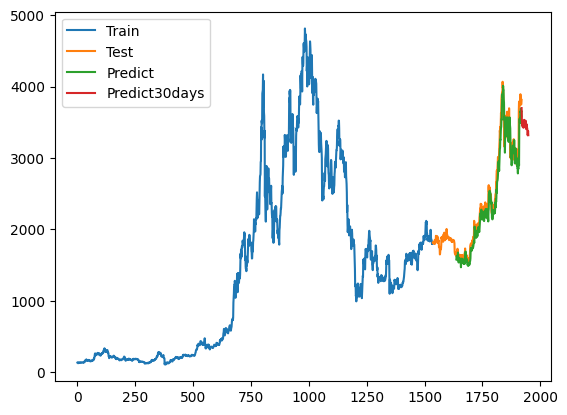

In [29]:
train_data_index = pd.RangeIndex(start=0, stop=train_size_82, step=1)
plt.plot(scaler.inverse_transform(train_data_82))
test_data_index = pd.RangeIndex(start=train_size_82, stop=train_size_82+test_size_82, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data_82))
test_data_index = pd.RangeIndex(start=train_size_82+101, stop=train_size_82+test_size_82, step=1)
plt.plot(test_data_index,(test_predict_82))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [30]:
train_size_91 = int(0.9 * len(df1))
test_size_91 = len(df1) - train_size_91
train_data_91 = df1[:train_size_91]
test_data_91 = df1[train_size_91:train_size_91+test_size_91]

In [31]:
X_train_91, y_train_91 = create_dataset(train_data_91, time_step)
X_test_91, ytest_91 = create_dataset(test_data_91, time_step)

In [32]:
X_train_91 =X_train_91.reshape(X_train_91.shape[0],X_train_91.shape[1] , 1)
X_test_91 = X_test_91.reshape(X_test_91.shape[0],X_test_91.shape[1] , 1)

In [33]:
model.fit(X_train_91,y_train_91,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
26/26 [==============================] - 0s 10ms/step - loss: 2.7843e-04
Epoch 2/100
26/26 [==============================] - 0s 10ms/step - loss: 3.5739e-04
Epoch 3/100
26/26 [==============================] - 0s 9ms/step - loss: 3.1905e-04
Epoch 4/100
26/26 [==============================] - 0s 10ms/step - loss: 2.5819e-04
Epoch 5/100
26/26 [==============================] - 0s 12ms/step - loss: 2.9649e-04
Epoch 6/100
26/26 [==============================] - 0s 10ms/step - loss: 3.8800e-04
Epoch 7/100
26/26 [==============================] - 0s 15ms/step - loss: 2.5132e-04
Epoch 8/100
26/26 [==============================] - 0s 16ms/step - loss: 2.5711e-04
Epoch 9/100
26/26 [==============================] - 0s 15ms/step - loss: 2.7275e-04
Epoch 10/100
26/26 [==============================] - 0s 17ms/step - loss: 2.3654e-04
Epoch 11/100
26/26 [==============================] - 0s 15ms/step - loss: 2.4472e-04
Epoch 12/100
26/26 [==============================] - 0s 17ms/st

In [34]:
train_predict_91 = model.predict(X_train_91)
test_predict_91 = model.predict(X_test_91)

3/3 [==============================] - 0s 5ms/step


In [35]:
train_predict_91 = scaler.inverse_transform(train_predict_91)
test_predict_91 = scaler.inverse_transform(test_predict_91)
y_train_91 = scaler.inverse_transform(y_train_91.reshape(-1, 1))
ytest_91 = scaler.inverse_transform(ytest_91.reshape(-1, 1))

In [36]:
train_91_rmse = np.sqrt(np.mean((train_predict_91 - y_train_91)**2))
test_91_rmse = np.sqrt(np.mean((test_predict_91 - ytest_91)**2))
test_91_mape = np.mean(np.abs((ytest_91 - test_predict_91) / ytest_91)) * 100
test_91_mse = np.mean((ytest_91 - test_predict_91)**2)

print('Train RMSE:', train_82_rmse)
print('Test RMSE:', test_82_rmse)
print('Test MAPE:', test_82_mape)
print('Test MSE:', test_82_mse)

Train RMSE: 78.72687624429284
Test RMSE: 122.1024981682291
Test MAPE: 3.758259776607654
Test MSE: 14909.020058922391


In [37]:
# Dự đoán 30 ngày tiếp theo và in ra màn hình
x_input = test_data_91[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.59790777 0.61295149 0.63854157 0.65264274 0.66657997 0.69660977
 0.68729693 0.70710649 0.70434052 0.7190048  0.74866357 0.73261135
 0.78881953 0.80054378 0.80431139 0.8092796  0.8019998  0.84140269
 0.82307402 0.8286433  0.80241398 0.77095152 0.72578276 0.75121155
 0.72474585 0.6480962  0.72376913 0.71942968 0.68554606 0.68616416
 0.71127167 0.74025132 0.73953263 0.72094495 0.73395759 0.72343159
 0.72261019 0.75236934 0.72199032 0.67353848 0.68081434 0.68477024
 0.68239753 0.6899055  0.7110288  0.76245899 0.72201867 0.73022326
 0.72203664 0.66626424 0.61561329 0.64795235 0.63618127 0.63263341
 0.61132255 0.62861498 0.62717947 0.64809812 0.6458991  0.65746217
 0.66134595 0.64430739 0.64786039 0.64225689 0.66820689 0.67046287
 0.66039249 0.61718439 0.60814422 0.61205443 0.63659425 0.63957936
 0.6437637  0.62791332 0.61596994 0.6089679  0.62223251 0.59538368
 0.59576884 0.59940596 0.60379983 0.58929341 0.62245289 0.60290043
 0.63458992 0.6407221  0.62985192 0.75577232 0.782

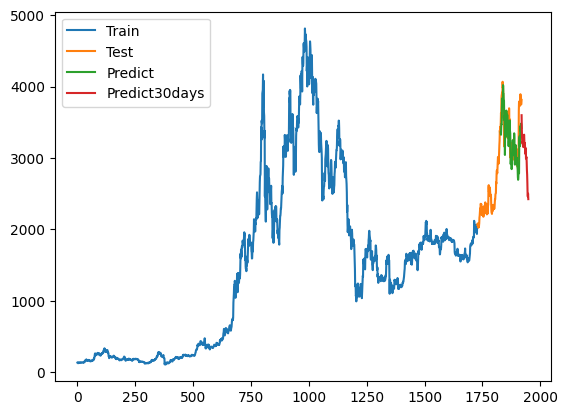

In [38]:
train_data_index = pd.RangeIndex(start=0, stop=train_size_91, step=1)
plt.plot(scaler.inverse_transform(train_data_91))
test_data_index = pd.RangeIndex(start=train_size_91, stop=train_size_91+test_size_91, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data_91))
test_data_index = pd.RangeIndex(start=train_size_91+101, stop=train_size_91+test_size_91, step=1)
plt.plot(test_data_index,(test_predict_91))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()